With this information, you could for all your original 
clusters plot a line in a graph with fraction of x-reduced 
size budgets that close on the y-axis against cluster 
surface area (possibly as fraction of original cluster 
              surface area) on the x-axis. 
The lines would start at 100% and original surface areas. 
The shape of those lines would give you a lot of 
information about the spatial scales that determine 
budget closure in each of the different regions 
in which your original clusters are located. 

In [1]:

import numpy as np
import xarray as xr
# import pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("/Users/ccamargo/Documents/github/SLB/")
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from utils_SLB import cluster_mean
#%%
def get_area(lat,lon,grid):
    
    ''' 
    given a certain grid, compute the area of each grid cell and the total surface area
    
    Inputs:
        lat: latitude, in decimal degrees
        lon: longitude, in decimal degrees,
        grid: grid with dimensions len(lat)xlen(lon)
        
    Outputs:
        surface_area (float): total surface area, in km**2:
        grid_area (matrix): area at each grid cell, in km**2
    '''

    R=6371 # Earth's radius in km
    
    #Check the grid resolution:
    deltalat=180/len(lat);
    deltalon=360/len(lon) 
    
    #Transform from degrees to km:

    deltay=(2*np.pi*R*deltalat)/360 #lat to km
    deltax=(2*np.pi*R*np.cos(np.radians(lat))*deltalon)/360 #lon to km
    
    area=np.array([deltax*deltay]*len(lon)).transpose()
    ocean_surf=np.nansum(area*grid)
    
    return ocean_surf, area


def find_central_coord(mask, lat, lon):
    '''
    given a mask, with 1 in the target area and nans everywhere else
    get the central latitude and longitude
    
    Inputs:
        lat (array, 1 or 2D): latitude array. Must be same dimension as mask
        lat (array, 1 or 2D): longitude array. Must be same dimension as mask
        mask (array, 1 or 2D): mask array.
        
    Outputs: 
        (central_lat,central_lon)
    '''
    if len(lat.shape) == 2: lat = lat.flatten()
    if len(lon.shape) == 2: lon = lon.flatten()
    if len(mask.shape) == 2: mask = mask.flatten()
    
    if len(mask.shape)>2:
        raise('Error: Only accept 1 or 2D array')
        
    if (len(mask) != len(lat)) or (len(mask) != len(lon)):
        raise('Error: dimensions do not match!')
    
    ind =np.array( 
        np.where(
            np.isfinite(mask))[0])
    ind = ind[int(len(ind)/2)]
    central_lat = lat[ind]
    central_lon = lon[ind]
    
    
    return (central_lat,central_lon)

In [2]:
#%% get budget components

path = '/Volumes/LaCie_NIOZ/data/budget/'
dic = pd.read_pickle(path+'budget_v2.pkl')
ds=xr.open_dataset(path+'trends/alt.nc')
lat = np.array(ds.lat)
lon = np.array(ds.lon)
llon,llat = np.meshgrid(lon,lat)
lonv = llon.flatten()
latv = llon.flatten()
dimlat = len(lat)
dimlon = len(lon)

In [3]:
#%% 
key ='som' # cluster
res = dic[key]['res']['trend'] # cluster residual trend
unc = dic[key]['res']['unc'] # cluster uncertainty
mask = dic[key]['mask'] # clusters mask
df = dic[key]['df']
# get area grid
surf, area = get_area(lat,lon,np.ones((dimlat,dimlon)) )

cluster_area = np.zeros((len(df)))
central_lat = np.full_like(cluster_area,0)
central_lon = np.full_like(cluster_area,0)
n_grid = np.full_like(cluster_area,0)

cluster_sig = np.full_like(cluster_area,0)
for i,icluster in enumerate(np.unique(mask[np.isfinite(mask)])):
    
    # cluster mask, 1 for the cluster, nan everywhere else
    mask_tmp = np.array(mask)
    mask_tmp [mask_tmp!=icluster] = np.nan
    mask_tmp [np.isfinite(mask_tmp)] = 1
    
    # area of the cluster
    cluster_area[i] = np.nansum(area*mask_tmp)
    
    # number of grid in cluster
    n_grid[i] = len(np.isfinite(mask_tmp))
    
    # get central lat and lon of the cluster
    central_lat[i], central_lon[i] =  find_central_coord(mask_tmp, llat, llon)
    
    # see if cluster is closed or not
    # 0 for closed, 1 for open
    if np.abs(df['res_tr'][i])< df['res_unc'][i]:
        cluster_sig[i] = 0
    else:
        cluster_sig[i] = 1

Text(0.5, 0.5, '\nsize of cluster')

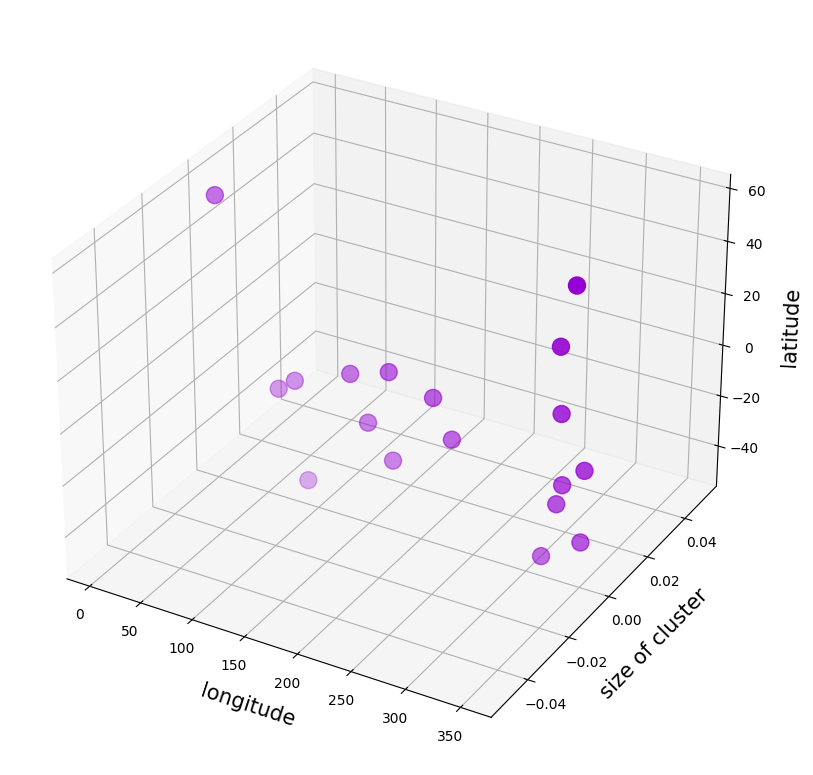

In [4]:
#%% plot
fontsize=15
fig = plt.figure(figsize=(15, 10),dpi=100)
ax = fig.add_subplot(111, projection="3d")

# Data for a three-dimensional line
x = np.array(central_lon)
y = np.array(n_grid)
z = np.array(central_lat)
c = np.array(cluster_sig)
col= ['salmon' if sig==1 else 'darkviolet' for sig in cluster_sig]


# ax.plot3D(
#     xline,
#     yline,
#     zline,
#     "gray",
# )
sc = ax.scatter3D(
    x,c,z,
    c=col,
    # cmap="plasma",
    s=150,
)
ax.set_xlabel("\nlongitude",fontsize=fontsize)
ax.set_zlabel("\nlatitude",fontsize=fontsize)
ax.set_ylabel("\nsize of cluster",fontsize=fontsize)
#%%

/Users/ccamargo/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


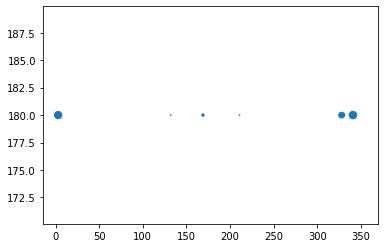

In [5]:
plt.scatter(x,y,z)


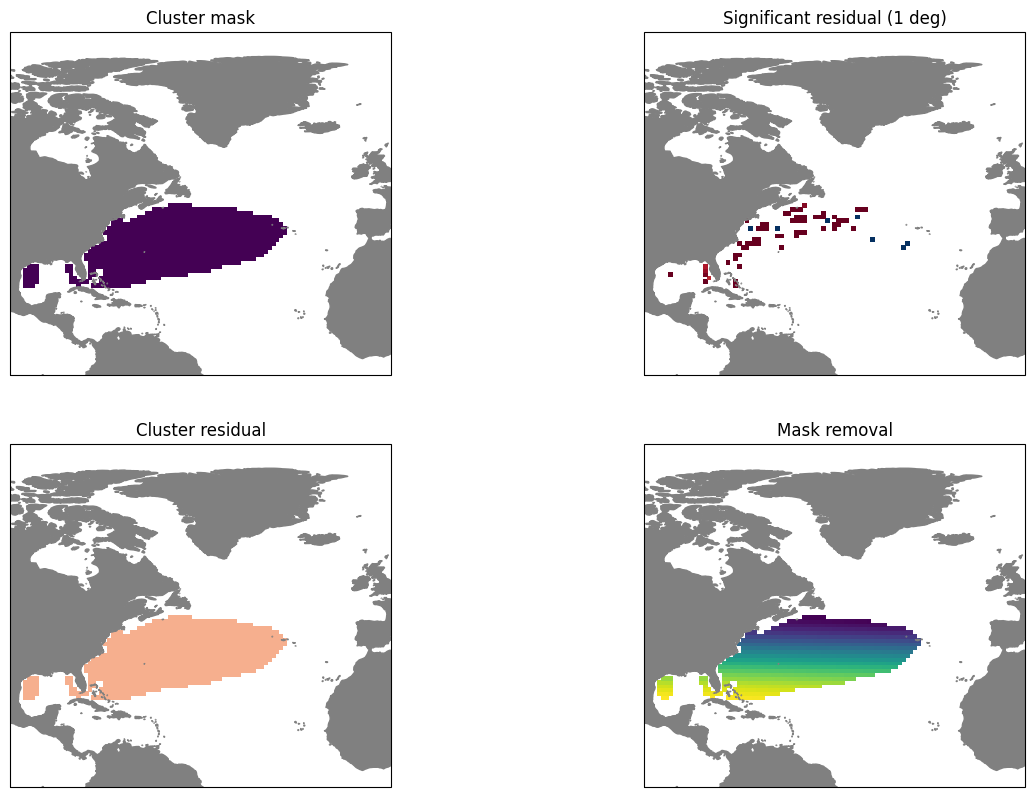

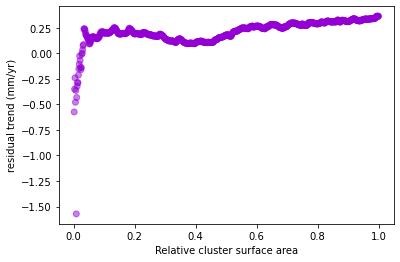

In [6]:
#%% try with only 1 cluster

landmask = np.array(dic['res']['trend'])
landmask[np.isfinite(landmask)]=1
res = np.array(dic['res']['trend'])
unc = np.array(dic['res']['unc'])
res_sig = np.array(dic['res']['trend'])
res_sig[np.where(np.abs(res)<unc)]=np.nan
key='som'
res_cl = np.array(dic[key]['res']['trend']) # cluster residual trend
unc_cl = np.array(dic[key]['res']['unc'] )# cluster uncertainty
res_sig_cl = np.array(dic[key]['res']['trend'] )
res_sig_cl[np.where(np.abs(res_cl)<unc_cl)]=np.nan
icluster = 1
mask_tmp = np.array(mask*landmask)
mask_tmp [mask_tmp!=icluster] = np.nan
mask_tmp [np.isfinite(mask_tmp)] = 1

plt.figure(dpi=100,figsize=(15,10))
nrow=2
ncol=2
extent=[-100,0,0,90]
proj=ccrs.PlateCarree()

ax = plt.subplot(nrow,ncol,1, projection=proj)
ax.pcolor(lon,lat,mask_tmp,
          transform=ccrs.PlateCarree()
          )
# ax.set_global()
ax.set_extent(extent,ccrs.PlateCarree())
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'land', '50m', 
        edgecolor='gray', facecolor='gray'))
plt.title('Cluster mask')


ax = plt.subplot(nrow,ncol,2, projection=proj)
ax.pcolor(lon,lat,
           res_sig*mask_tmp, 
           transform=ccrs.PlateCarree(),
           vmin=-1,vmax=1,cmap='RdBu_r')
ax.set_extent(extent,ccrs.PlateCarree())
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'land', '50m', 
        edgecolor='gray', facecolor='gray'))
plt.title('Significant residual (1 deg)')

ax = plt.subplot(nrow,ncol,3, projection=proj)
ax.pcolor(lon,lat,
           res_cl*mask_tmp, 
           transform=ccrs.PlateCarree(),
           vmin=-1,vmax=1,cmap='RdBu_r')
ax.set_extent(extent,ccrs.PlateCarree())
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'land', '50m', 
        edgecolor='gray', facecolor='gray'))
plt.title('Cluster residual')

# plt.tight_layout()
# plt.show()
#% %
# get indexes
inds = np.array(
    np.where(
        np.isfinite(mask_tmp)))
size = len(inds[0])
new_trend = np.zeros((size))
new_unc = np.zeros((size))
new_sig = np.zeros((size))
new_area = np.zeros((size))
central_lat = np.zeros((size))
central_lon = np.zeros((size))

masks = np.zeros((size,dimlat,dimlon))
i=0
masks[i] = np.array(mask_tmp)
new_trend[i] = df['res_tr'][icluster-1]
new_unc[i] = df['res_unc'][icluster-1]
if new_trend[i]< new_unc[i]:
    new_sig[i] = 0
else:
    new_sig[i] = 1
new_area[i], a = get_area(lat,lon,mask_tmp)
mask_removal = np.full_like(mask_tmp,np.nan)

# i=1
# for ilat,ilon in zip(inds[0],inds[1]):
#for i in range(size-1,0,-1):
for i in range(1,size):

    ilat = np.flip(inds[0])[i-1]
    ilon = np.flip(inds[1])[i-1]
    
    mask_tmp[ilat,ilon] = np.nan
    mask_removal[ilat,ilon] = i
    masks[i] = np.array(mask_tmp)

    new_area[i], a = get_area(lat,lon,mask_tmp)
    new_trend[i] = cluster_mean(dic['res']['trend'],mask_tmp,lat=lat,lon=lon,norm=False )
    new_unc[i] = cluster_mean(dic['res']['unc'],mask_tmp,lat=lat,lon=lon,norm=False )
    if np.abs(new_trend[i])< new_unc[i]:
        new_sig[i] = 0
    else:
        new_sig[i] = 1
    central_lat[i], central_lon[i] =  find_central_coord(mask_tmp, llat, llon)

ax = plt.subplot(nrow,ncol,4, projection=proj)
ax.pcolor(lon,lat,mask_removal,
          transform=ccrs.PlateCarree()
          )
# ax.set_global()
ax.set_extent(extent,ccrs.PlateCarree())
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'land', '50m', 
        edgecolor='gray', facecolor='gray'))
plt.title('Mask removal')

plt.show()

    # i=i+1
#% %
plt.figure()
plt.scatter(new_area/new_area[0],new_trend,
            c = ['salmon' if sig==1 else 'darkviolet' for sig in new_sig],
            # c = new_sig,
            alpha=0.5
            ) 
plt.xlabel('Relative cluster surface area')
plt.ylabel('residual trend (mm/yr)')
plt.show()
# plt.scatter(new_area[new_sig==1],
#             new_trend[new_sig==1],
#             c='black',
#             s=100)


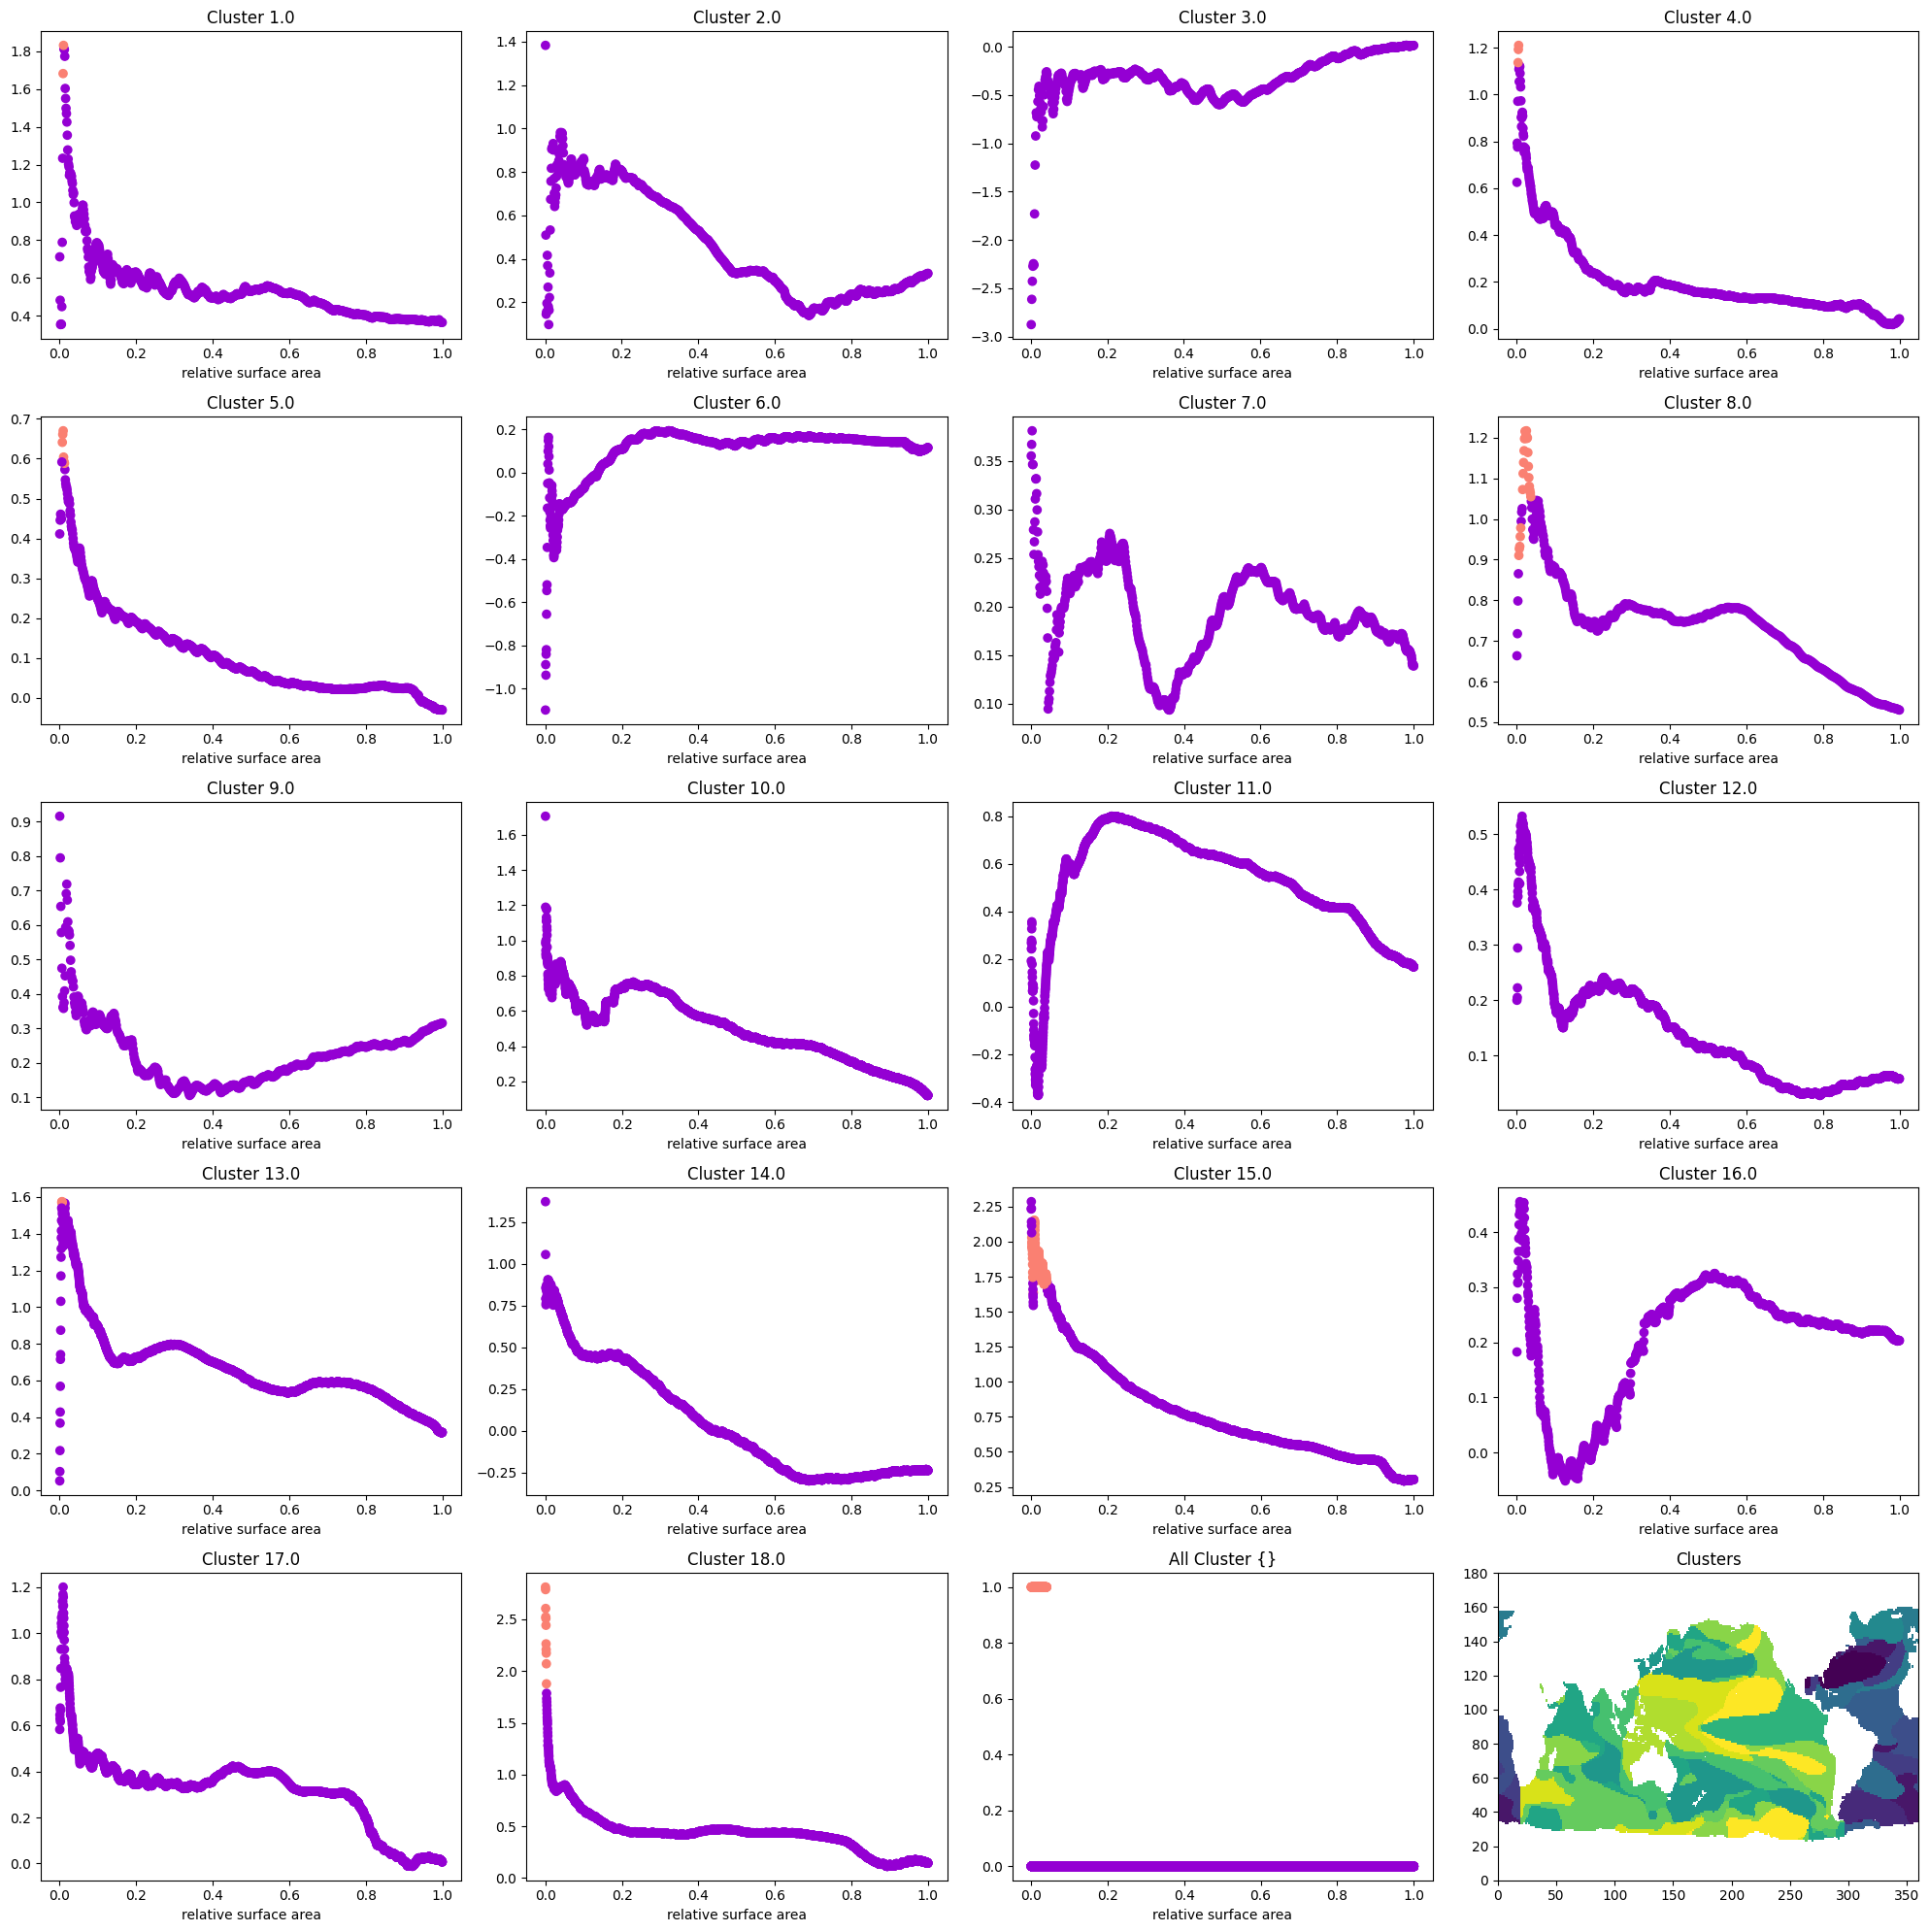

In [7]:
#%% all clusters
landmask = np.array(dic['res']['trend'])
landmask[np.isfinite(landmask)]=1

T = []
U = []
A = []
S = []
N = []
x=4
y=5
plt.figure(figsize=(20,20),dpi=100)

mask_removal_total = np.zeros((dimlat,dimlon))
for icluster in np.unique(mask[np.isfinite(mask)]):
    # print(icluster)
    mask_tmp = np.array(mask*landmask)
    mask_tmp [mask_tmp!=icluster] = np.nan
    mask_tmp [np.isfinite(mask_tmp)] = 1
    # plt.pcolor(mask_tmp)
    # get indexes
    inds = np.array(
        np.where(
            np.isfinite(mask_tmp)))
    size = len(inds[0])
    new_trend = np.zeros((size))
    new_unc = np.zeros((size))
    new_sig = np.zeros((size))
    new_area = np.zeros((size))
    new_n = np.zeros((size))
    masks = np.zeros((size,dimlat,dimlon))
    i=0
    masks[i] = np.array(mask_tmp)
    new_trend[i] = df['res_tr'][icluster-1]
    new_unc[i] = df['res_unc'][icluster-1]
    if new_trend[i]< new_unc[i]:
        new_sig[i] = 0
    else:
        new_sig[i] = 1
    new_area[i], a = get_area(lat,lon,mask_tmp )
    mask_removal = np.full_like(mask_tmp,np.nan)
    # i=1
    # for ilat,ilon in zip(inds[0],inds[1]):
    for i in range(1,size):
        ilat = inds[0][i-1]
        ilon = inds[1][i-1]
        
        mask_tmp[ilat,ilon] = np.nan
        mask_removal[ilat,ilon] = i
        masks[i] = np.array(mask_tmp)
        new_n[i] = len(mask_tmp[np.isfinite(mask_tmp)])
        new_area[i], a = get_area(lat,lon,mask_tmp)
        new_trend[i] = cluster_mean(dic['res']['trend'],mask_tmp,lat=lat,lon=lon,norm=False )
        new_unc[i] = cluster_mean(dic['res']['unc'],mask_tmp,lat=lat,lon=lon,norm=False )
        if new_trend[i]< new_unc[i]:
            new_sig[i] = 0
        else:
            new_sig[i] = 1
        # i=i+1
    
    A.extend(new_area/new_area[0])
    T.extend(new_trend)
    U.extend(new_unc)
    S.extend(new_sig)
    N.extend(new_n)
    mask_removal_total[np.where(mask_tmp==1)] = mask_removal[np.where(mask_tmp==1)]

    ax = plt.subplot(y,x,int(icluster))
    plt.scatter(new_area/new_area[0], 
                new_trend,
                c = ['salmon' if sig==1 else 'darkviolet' for sig in new_sig]
                )
    plt.title('Cluster {}'.format(icluster))
    plt.xlabel('relative surface area')

##
ax = plt.subplot(y,x,int(icluster)+1)
plt.scatter(A, 
            S,
            c = ['salmon' if sig==1 else 'darkviolet' for sig in S]
            )
plt.title('All Cluster {}')
plt.xlabel('relative surface area')

ax = plt.subplot(y,x,int(icluster)+2)
plt.pcolor(mask,vmin=1,vmax=18)
plt.title('Clusters')


# ax = plt.subplot(y,x,int(icluster)+2)
# plt.pcolor(mask_removal_total,vmin=0,vmax=500)
# plt.title('Cluster removal')

plt.tight_layout()

plt.show()

In [8]:
#%%
df2 = pd.DataFrame({'area':A,
                    'trend':T,
                    'unc':U,
                    'sig':S,
                    'size':N})
df2.sort_values(['size'],inplace=True)

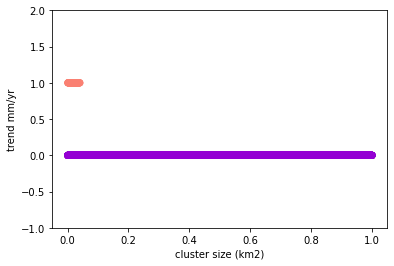

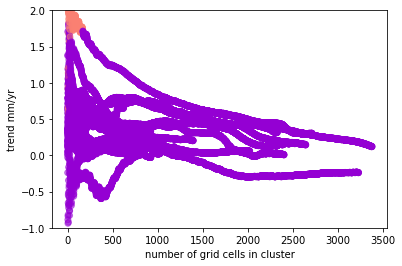

In [9]:
plt.figure()
plt.subplot(111)
plt.scatter(A,S,
            c = ['salmon' if sig==1 else 'darkviolet' for sig in S],
            # c = new_sig,
            alpha=0.5
            ) 
plt.ylim([-1,2])
# plt.xlim([5000,100000])
plt.ylabel('trend mm/yr')
plt.xlabel('cluster size (km2)')
plt.show()

plt.figure()
plt.subplot(111)
plt.scatter(df2['size'],df2['trend'],
            c = ['salmon' if sig==1 else 'darkviolet' for sig in df2['sig']],
            # c = new_sig,
            alpha=0.5
            ) 
plt.ylim([-1,2])
# plt.xlim([5000,100000])
plt.ylabel('trend mm/yr')
plt.xlabel('number of grid cells in cluster')

plt.show()